In [1]:
# import pandas as pd
# from datetime import datetime, timedelta
# # خواندن فایل CSV
# df = pd.read_csv("power_code.csv")
# # تبدیل تاریخ با فرمت‌های مختلف
# df['DATE_MILADI'] = pd.to_datetime(df['DATE_MILADI'], format='mixed', errors='coerce')

# # حذف ردیف‌هایی که تبدیل تاریخ در آن‌ها ناموفق بوده
# df = df.dropna(subset=['DATE_MILADI'])
# # ساخت ستون جدید DATE با ساعت اصلاح‌شده از ستون HOUR
# df['DATE'] = df.apply(lambda row: row['DATE_MILADI'].replace(hour=int(row['HOUR']) % 24), axis=1)

# # نمایش چند سطر اول برای بررسی
# print(df[['DATE_MILADI', 'HOUR', 'DATE']].head())

# # ذخیره فایل جدید در صورت نیاز
# df.to_csv('updated_file.csv', index=False)

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from darts import TimeSeries
import pandas as pd
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

c:\Users\pishva_r\Anaconda3\envs\test2\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
df = pd.read_csv("../BackUp/updated_file.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='mixed', errors='coerce')
df = df.dropna(subset=['DATE'])

In [4]:
target_date = pd.to_datetime('6/28/2025 1:00:00 AM')
df_filtered = df[(df['UNIT_NO'] == 2) & (df['DATE'] >= target_date)]
print(df_filtered.head())


          ID_NO  HOUR DATE_MILADI DATE_SHAMSI  POWER CODE  UNIT_NO  ID_EBRAZ  \
966214  1490053     1   6/28/2025    1404/4/7     96   SO        2   1427858   
966215  1490054     2   6/28/2025    1404/4/7     96   SO        2   1427859   
966216  1490055     3   6/28/2025    1404/4/7     97   SO        2   1427860   
966217  1490056     4   6/28/2025    1404/4/7     90   SO        2   1427861   
966218  1490057     5   6/28/2025    1404/4/7     90   SO        2   1427862   

       CODE3  MVAR  DAMA  ROTOOBAT   TOTAL                DATE  
966214     A  21.0  26.0      13.0  1050.0 2025-06-28 01:00:00  
966215     A  19.0  25.0      15.0  1052.0 2025-06-28 02:00:00  
966216     A  19.0  23.0      17.0  1059.0 2025-06-28 03:00:00  
966217     A  18.0  24.0      18.0   992.0 2025-06-28 04:00:00  
966218     A  15.0  24.0      18.0   996.0 2025-06-28 05:00:00  


In [5]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
duplicates = df_filtered['DATE'].duplicated().sum()
print(f"duplicates rows: {duplicates}")


duplicates rows: 0


In [7]:
df_filtered = df_filtered.drop_duplicates(subset='DATE')
# df_filtered = df_filtered.groupby('DATE', as_index=False).agg({'POWER': 'mean'})

In [8]:
series = TimeSeries.from_dataframe(
    df_filtered,
    time_col='DATE',
    value_cols='POWER',
    freq='h'  
)

In [9]:
covariates = TimeSeries.from_dataframe(df_filtered, time_col='DATE', value_cols='MVAR', freq='h')

In [10]:
# scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
# series_scaled = scaler.fit_transform(series)

scaler_series = Scaler(MinMaxScaler(feature_range=(0, 1)))
series_scaled = scaler_series.fit_transform(series)
scaler_cov = Scaler(MinMaxScaler(feature_range=(0, 1)))
covariates_scaled = scaler_cov.fit_transform(covariates)

In [11]:
train_ratio = 0.95
# train, test = series_scaled.split_after(train_ratio)


train_series, test_series = series_scaled.split_after(train_ratio)
train_cov, test_cov = covariates_scaled.split_after(train_ratio)

print(f"train data: {len(train_series)} hour")
print(f"test data: {len(test_series)} hour")


train data: 272 hour
test data: 15 hour


In [12]:
# model = RNNModel(
#     model='LSTM', 
#     hidden_dim=100,
#     n_rnn_layers=6,   
#     dropout=0.2, 
#     input_chunk_length=24, 
#     output_chunk_length=12, 
#     training_length=36, 
#     n_epochs=100,
#     random_state=42 
# )

In [13]:
from darts.models import BlockRNNModel

model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_dim=64,
    n_rnn_layers=10,
    dropout=0.2,
    n_epochs=100,
    random_state=42
)

model.fit(
    series=train_series,
    past_covariates=train_cov,
    verbose=True
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 316 K  | train
6 | fc              | Sequential       | 780    | train
-------------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.271     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=10, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=42)

In [14]:
pred = model.predict(n=len(test_series), series=train_series, past_covariates=covariates_scaled)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [15]:
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

In [16]:
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")

RMSE: 3.24
MAE: 3.08


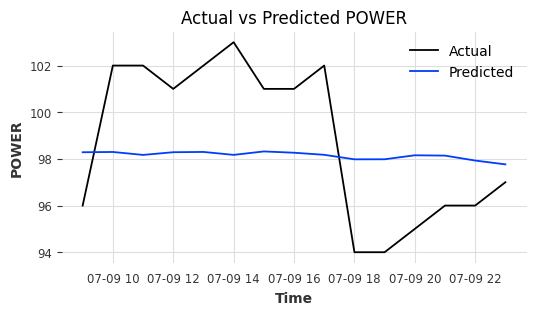

In [17]:
# تبدیل سری‌ها به pandas
df_test = test_series.pd_dataframe()
df_pred = pred.pd_dataframe()

# رسم نمودار
plt.figure(figsize=(6, 3))
plt.plot(df_test.index, df_test['POWER'], label='Actual')
plt.plot(df_pred.index, df_pred['POWER'], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted POWER")
plt.xlabel("Time")
plt.ylabel("POWER")
plt.grid(True)
plt.show()
